<a href="https://colab.research.google.com/github/phamquiluan/baro/blob/main/tutorials/how-to-use-baro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BARO Tutorials

In this tutorial, we use BARO to perform anomaly detection and root cause analysis on a failure case of the Online Boutique dataset.

## Install BARO

In [ ]:
%pip install --no-cache -q -U fse-baro

## Import modules

In [ ]:
import os
import pandas as pd
from baro.utility import visualize_metrics, download_data

# Download sample data

### Data format

The data must be a `pandas.DataFrame` that consists of multivariate time series metrics data. We require the data to have a column named `time` that stores the timestep. Each other column stores a time series for metrics data with the name format of `<service>_<metric>`. For example, the column `cart_cpu` stores the CPU utilization of service `cart`. A sample of valid data could be downloaded using the `download_data()` method that we will demonstrated shortly below.
The downloaded metrics data are collected from the Online Boutique system, the ground truth root cause is `carts_cpu`.

In [ ]:
download_data() # it downloads sample data to `data.csv`
df = pd.read_csv("data.csv")
df = df[60:660].reset_index(drop=True)
df.head(5)

,time,adservice_cpu,cartservice_cpu,checkoutservice_cpu,currencyservice_cpu,emailservice_cpu,frontend_cpu,main_cpu,paymentservice_cpu,productcatalogservice_cpu,...,adservice_latency-90,cartservice_latency-90,checkoutservice_latency-90,currencyservice_latency-90,emailservice_latency-90,frontend_latency-90,paymentservice_latency-90,productcatalogservice_latency-90,recommendationservice_latency-90,shippingservice_latency-90
0,1692569039,0.934392,4.529217,0.779652,6.817210,0.650330,14.340541,5.183202,0.366328,7.19223,...,0.004296,0.006204,0.047070,0.004366,0.004654,0.148814,0.004366,0.003872,0.008390,0.004185
1,1692569040,0.934392,4.529217,0.595016,6.817210,0.661076,14.340541,5.183202,0.366328,7.19223,...,0.004296,0.006212,0.047227,0.004366,0.004651,0.148814,0.004370,0.003887,0.008249,0.004187
2,1692569041,0.934392,4.529217,0.681441,6.817210,0.661076,14.340541,6.104681,0.357983,7.19223,...,0.004296,0.006212,0.047227,0.004366,0.004651,0.158764,0.004370,0.003887,0.008249,0.004187
3,1692569042,0.934392,4.529217,0.889760,6.906393,0.661076,14.340541,7.490554,0.357983,7.19223,...,0.004296,0.006212,0.047227,0.004366,0.004651,0.147773,0.004387,0.003887,0.008249,0.004187
4,1692569043,0.934392,4.529217,0.889760,6.906393,0.661076,14.457969,7.490554,0.288518,7.17395,...,0.004302,0.006551,0.047258,0.004383,0.004651,0.157887,0.004371,0.003888,0.008284,0.004154


# Visualize the metrics

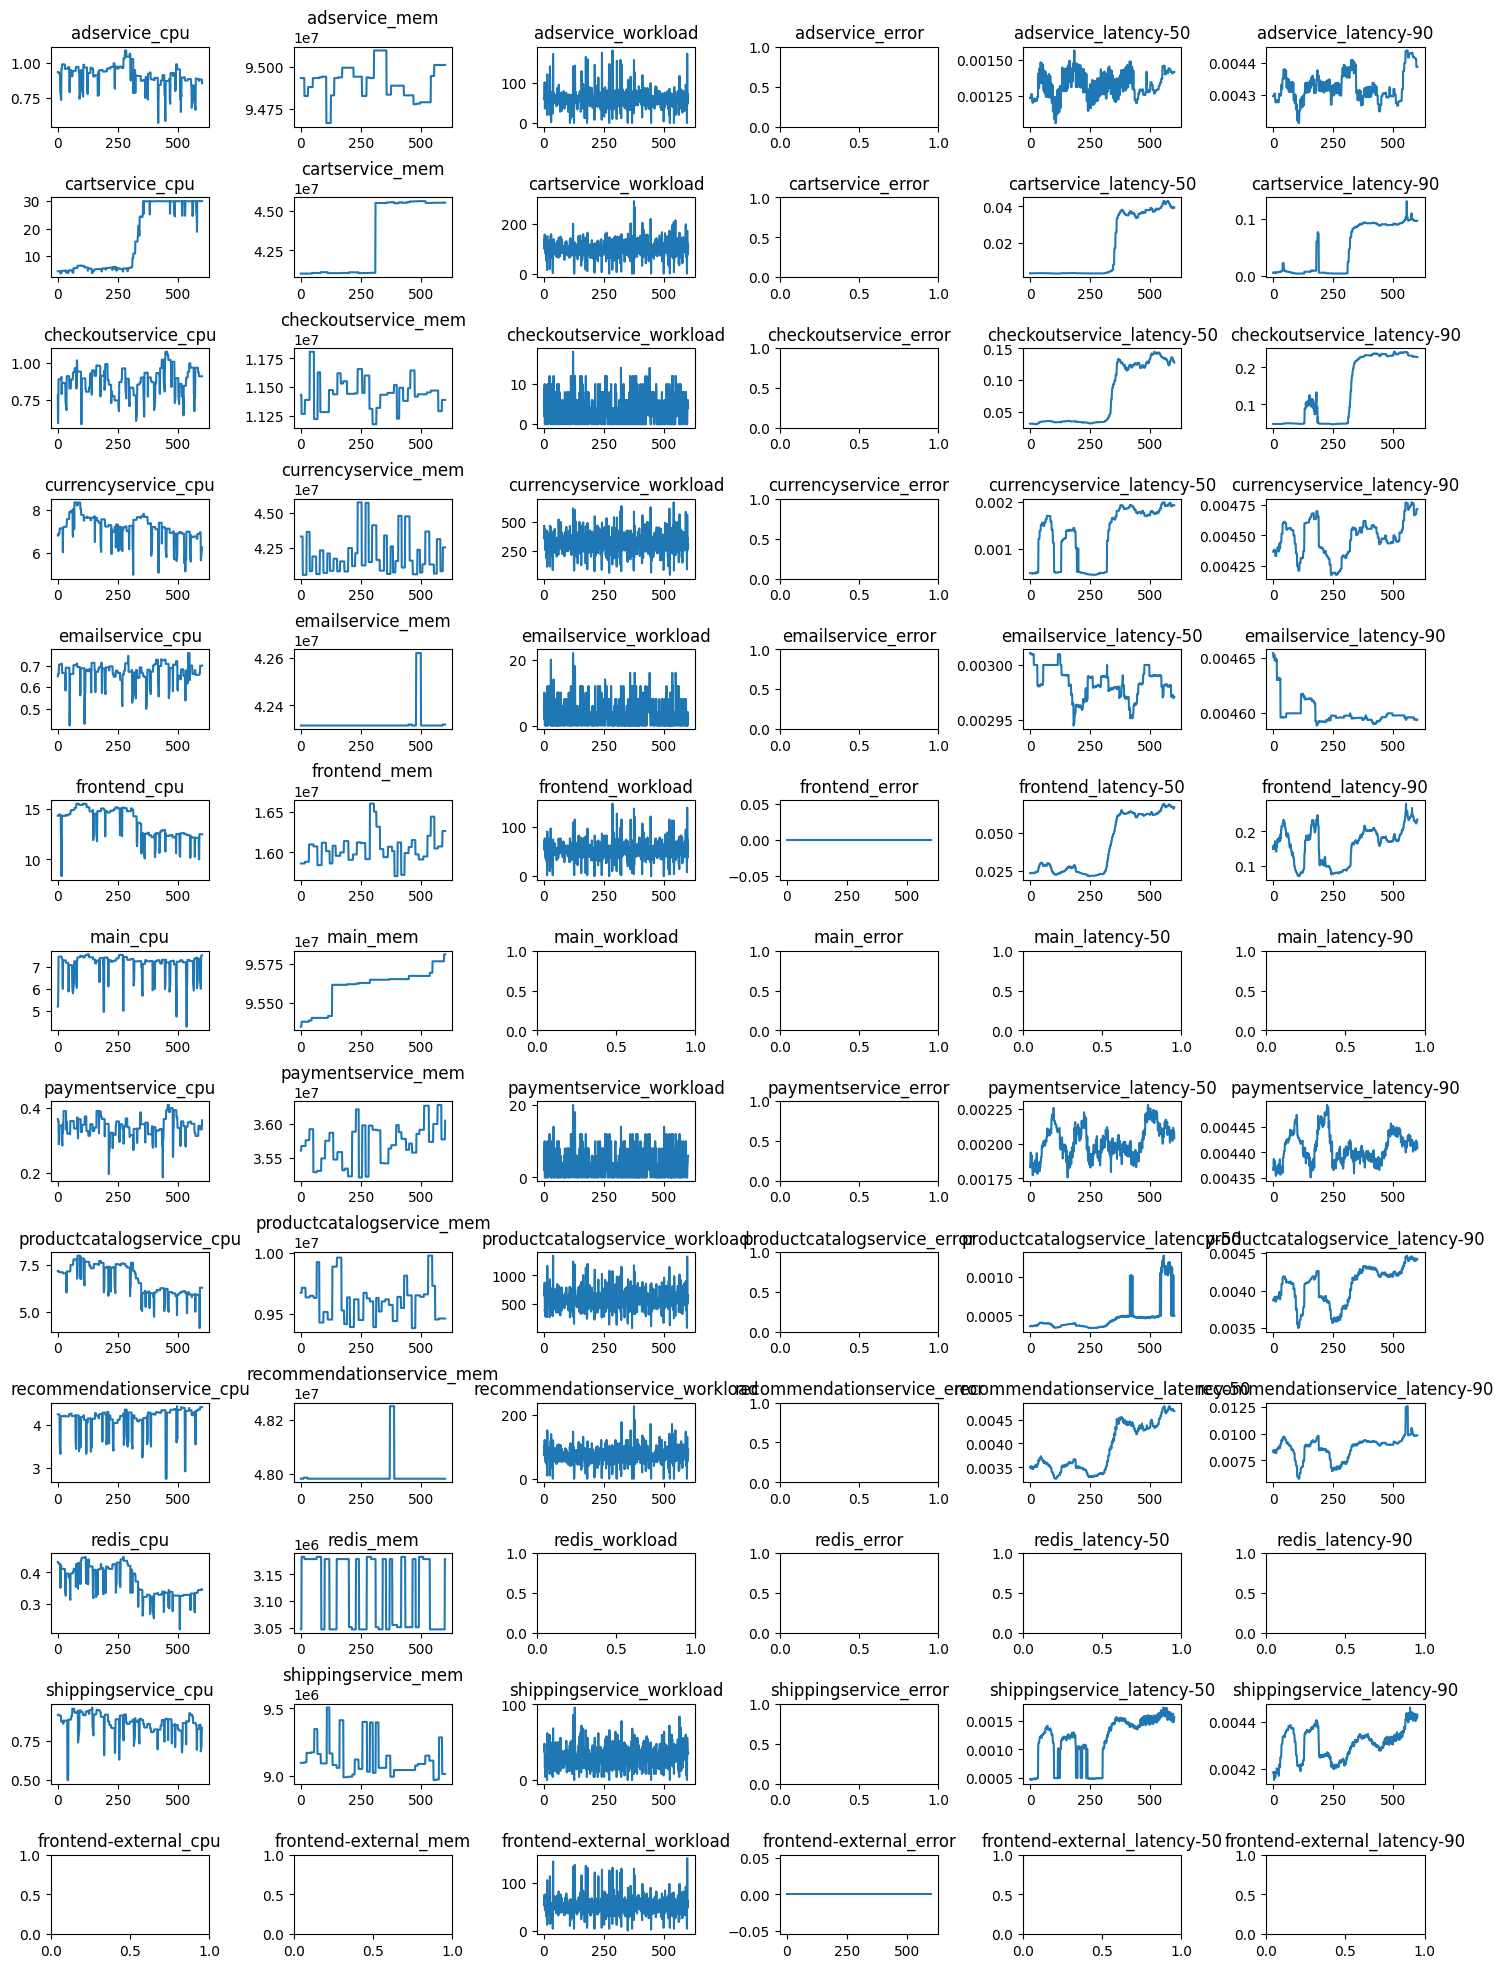

In [ ]:
import matplotlib.pyplot as plt
visualize_metrics(df, figsize=(15, 20))

# Anomaly Detection

In this section, we perform anomaly detection using Multivariate BOCPD (`bocpd`). As mentioned in our paper, we perform anomaly detection on `latency` and `error` metrics.

In [ ]:
# import modules
from baro.anomaly_detection import bocpd, nsigma
from baro.utility import drop_constant

# select latency and error rate
time_col = pd.Series(range(df.shape[0])) # df["time"]
selected_cols = [c for c in df.columns if "latency-50" in c or "error" in c]
selected_df = drop_constant(df[selected_cols])
selected_df.insert(0, "time", time_col)
selected_df.head(5)

,time,adservice_latency-50,cartservice_latency-50,checkoutservice_latency-50,currencyservice_latency-50,emailservice_latency-50,frontend_latency-50,paymentservice_latency-50,productcatalogservice_latency-50,recommendationservice_latency-50,shippingservice_latency-50
0,0,0.001238,0.003246,0.031445,0.000468,0.003011,0.023312,0.001832,0.000360,0.003510,0.000478
1,1,0.001238,0.003246,0.031445,0.000468,0.003010,0.023312,0.001850,0.000362,0.003485,0.000480
2,2,0.001238,0.003246,0.031445,0.000468,0.003010,0.023460,0.001850,0.000362,0.003485,0.000480
3,3,0.001238,0.003246,0.031445,0.000468,0.003010,0.023399,0.001937,0.000362,0.003485,0.000480
4,4,0.001257,0.003253,0.031452,0.000470,0.003010,0.023556,0.001855,0.000362,0.003489,0.000463


In [ ]:
# perform anomaly detection with Multivariate BOCPD
anomalies = bocpd(selected_df)
print("Anomalies detected by Multivariate BOCPD at timestamp:", anomalies[:5])

Anomalies detected by Multivariate BOCPD at timestamp: [332]


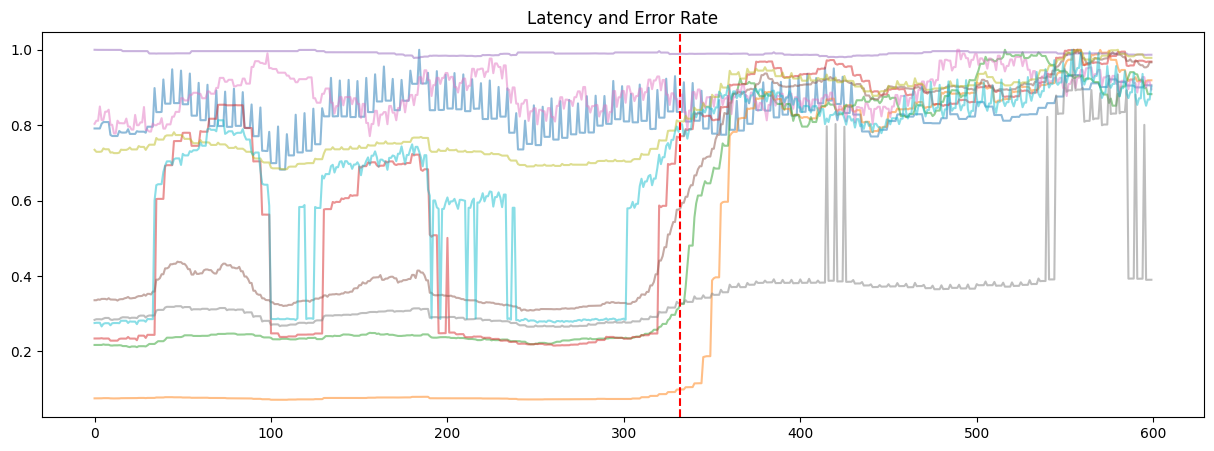

In [ ]:
# plotting the detected anomaly
for c in selected_df.columns:
    if c == "time": continue
    selected_df[c] /= selected_df[c].max()
selected_df.drop("time", axis=1).plot(figsize=(15, 5), title="Latency and Error Rate", alpha=0.5, legend=None)

# draw vertical RED line at anomalies[0]
plt.axvline(x=anomalies[0], color='r', linestyle='--')

# Root Cause Analysis

In [ ]:
from baro.root_cause_analysis import robust_scorer
robust_scorer(df, anomalies=anomalies)["ranks"]

['cartservice_latency-50',
 'checkoutservice_latency-90',
 'cartservice_mem',
 'checkoutservice_latency-50',
 'cartservice_latency-90',
 'cartservice_cpu',
 'productcatalogservice_latency-50',
 'frontend_latency-50',
 'recommendationservice_workload',
 'recommendationservice_latency-50',
 'cartservice_workload',
 'adservice_workload',
 'frontend-external_workload',
 'frontend_workload',
 'productcatalogservice_workload',
 'currencyservice_workload',
 'adservice_latency-90',
 'shippingservice_workload',
 'emailservice_cpu',
 'adservice_mem',
 'recommendationservice_latency-90',
 'recommendationservice_cpu',
 'adservice_latency-50',
 'frontend_mem',
 'emailservice_workload',
 'currencyservice_mem',
 'paymentservice_cpu',
 'frontend_latency-90',
 'productcatalogservice_mem',
 'checkoutservice_workload',
 'paymentservice_workload',
 'currencyservice_latency-50',
 'currencyservice_latency-90',
 'productcatalogservice_latency-90',
 'paymentservice_latency-50',
 'checkoutservice_cpu',
 'shipp